# Modèles de classification

Ce notebook contient les différents essais de modélisation que j'ai lancé pour ségmenter les clients. Ce sont des approches non supervisées :
* modèle hiérarchique sur RMF
* modèle DBSCAN 
* kmeans 


J'ai lancé ces modèles sur deux jeux de données extraits de l'analyse exploratoire. Le premier, constitué de 3 variables, est issu d'un modèle de marketing, le RMF. Le deuxième est l'aggrégation des différentes tables, à l'échelle des commandes, et je n'ai considéré que la dernière commande de chaque client (modèle qui exploite mieux les caractéristiques des différentes tables, mais est sans mémoire). 


# Reconstruction des tables

Je propose de résumer le travail d'analyse exploiratoire présenté dans le premier notebook, pour en faire un script actionnable pour extraire les tables de travail. Ce travail est dans le script "script00_P4_preprocessing"

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


data_path = "/home/clairegayral/Documents/openclassroom/data/P4/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P4/"

## my .py : 
# from script00_P4_preprocessing import *
from script01_duplicates import *
from script02_missing_values_treatment import *
from script03_univariate_analysis import *
from script04_multivariate_analysis import *
from script05_CV_regression import *
from script06_reduce_dim import *
from script07_customer_clustering import *
# my_customers.to_csv(res_path+"checkpoints/"+"my_customers.csv")
# my_orders.to_csv(res_path+"checkpoints/"+"my_orders.csv")
# my_products.to_csv(res_path+"checkpoints/"+"my_products.csv")
# rfm.to_csv(res_path+"checkpoints/"+"rfm.csv")
rfm = pd.read_csv(res_path+"checkpoints/"+"rfm.csv",index_col=0)
my_orders = pd.read_csv(res_path+"checkpoints/"+"my_orders.csv",index_col=0)



from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import linear_model

from sklearn.impute import KNNImputer
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics.pairwise import pairwise_kernels


from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# 1. Clustering sur RFM :

In [2]:
rfm_df = rfm.copy()

# Removing (statistical) outliers for monetary_value
Q1 = rfm_df.monetary_value.quantile(0.05)
Q3 = rfm_df.monetary_value.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.monetary_value >= Q1 - 1.5*IQR) & (rfm_df.monetary_value <= Q3 + 1.5*IQR)]

# # Removing (statistical) outliers for recency
# Q1 = rfm_df.recency.quantile(0.05)
# Q3 = rfm_df.recency.quantile(0.95)
# IQR = Q3 - Q1
# rfm_df = rfm_df[(rfm_df.recency >= Q1 - 1.5*IQR) & (rfm_df.recency <= Q3 + 1.5*IQR)]

# # Removing (statistical) outliers for frequency
# Q1 = rfm_df.frequency.quantile(0.05)
# Q3 = rfm_df.frequency.quantile(0.95)
# IQR = Q3 - Q1
# rfm_df = rfm_df[(rfm_df.frequency >= Q1 - 1.5*IQR) & (rfm_df.frequency <= Q3 + 1.5*IQR)]

Normalement, vu que je suis en non-supervisé, je n'aurai pas besoin d'isoler un ensemble d'entrainement.

In [3]:
# ## split data :
# X_train, X_test = model_selection.train_test_split(rfm_df)

# ## Standardize : 
# my_std = preprocessing.StandardScaler()
# my_std.fit(X_train)
# X_train_std = pd.DataFrame(my_std.transform(X_train), 
#                              index= X_train.index, columns=X_train.columns)
# X_test_std = pd.DataFrame(my_std.transform(X_test), 
#                              index= X_test.index, columns=X_test.columns)

X_train = rfm_df
## Standardize : 
my_std = preprocessing.StandardScaler()
my_std.fit(X_train)
X_train_std = pd.DataFrame(my_std.transform(X_train), 
                             index= X_train.index, columns=X_train.columns)

## 1.2 Kmeans : 

In [4]:
# list_n_clusters = np.arange(2,30,2)
# # Elbow-Method/SSD 
# ssd = []
# for num_clusters in list_n_clusters:
#     kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
#     kmeans.fit(X_train_std)
#     ssd.append(kmeans.inertia_)
    
# # plot the SSDs for each n_clusters
# plt.plot(list_n_clusters,ssd)
# plt.savefig(res_path+"figures/"+"RFM_kmeans_intertia.jpg")
# plt.show()

In [5]:
# ## compute kmeans on elbow
# n_clusters  = 8
# cls_meth = KMeans(init="k-means++")
# cls_meth.set_params(n_clusters  = n_clusters)
# cls_meth.fit(X_train_std)
# labels = pd.Series(cls_meth.labels_, index = X_train_std.index)

# ## plot on 3d 
# ax = cluster_scatter(X_train_std, labels,(10,6))    
# ax.view_init(10, 250)
# plt.show()
# ax = cluster_scatter(X_train_std, labels,(10,6))    
# ax.view_init(10, 0)
# plt.show()

Les clusters on l'air d'être parfaitement séparés par les différentes valeurs de "frequency". Je vais regarder sur ces differents plans :

In [6]:
# plot_projection_on_frequency_values(X_train, labels, [1,2])

Effectivement, les clusters sont presque parfaitement séparés. La grande majorité des points conserne les clients n'ayant passé qu'une seule commande. Je regarde comment s'aggrègent les clusters quand on augmente le nombre de clusters :

In [7]:
# cls_meth = KMeans(init="k-means++")
# for n_clusters in np.arange(5,12):
#     print("n_clusters = ",n_clusters)
#     cls_meth.set_params(n_clusters  = n_clusters)
#     cls_meth.fit(X_train_std)
#     labels = pd.Series(cls_meth.labels_, index = X_train_std.index)

#     plot_projection_on_frequency_values(X_train, labels, [1,2])


Bien que ces plans linéaires ont l'air de bien séparer les consommateurs, je voulais essayer des méthodes  aggrégatives, mais elles font planter mon noyau (DBSCAN, AgglomerativeClustering). J'ai donc pris un échantillon pour les faire tourner. 

## 1.2 DBSCAN
J'ai commencé par chercher des structures plus locales avec BDSCAN. Le code suivant a été modifié par soucis de lisibilité (j'ai cherché le meilleur epsilon, aui s'est trouvé être 3.


In [8]:
# from sklearn.cluster import DBSCAN
# sample = X_train.sample(5000)
# sample_std = my_std.transform(sample)

# cls_meth = DBSCAN(eps=3, min_samples=2)
# for eps in np.arange(3,3.1,0.11):
#     print("eps = ",eps)
#     cls_meth.set_params(eps  = eps)
#     cls_meth.fit(sample_std)
#     labels = pd.Series(cls_meth.labels_, index = sample.index)

#     plot_projection_on_frequency_values(sample, labels, [1,2])


Cette méthode n'arrive pas à séparer les consommateurs qui sont dans des plans différents (qui sont avec différentes frequency). Je vais le lancer sur le plan "frequency=1" pour voir s'il peut distinguer des partitions dedans.

In [9]:
# from sklearn.cluster import DBSCAN
# sample = X_train[X_train.frequency == 1].sample(5000)
# sample_std = pd.DataFrame(my_std.transform(sample),
#                           columns=sample.columns, index=sample.index)

# cls_meth = DBSCAN(eps=3, min_samples=2)
# for eps in np.arange(0.01,0.1,0.01):
#     print("eps = ",eps)
#     cls_meth.set_params(eps  = eps)
#     cls_meth.fit(sample_std)
#     labels = pd.Series(cls_meth.labels_, index = sample.index)

#     plot_projection_on_frequency_values(sample, labels, [0])


Il n'a pas l'air d'y avoir de structure locale ici.

## 1.3 Classification hierarchique
J'ai commencé par faire tourner la classification hierarchique implémentée dans scipy :

In [10]:
# from scipy.cluster.hierarchy import linkage, fcluster
# ## get a sample
# sample = X_train_std.sample(5000)
# # Clustering hiérarchique
# Z = linkage(sample, 'ward')

# # Affichage du dendrogramme
# # plot_dendrogram(Z, sample.index, figsize = (15,10))
# plot_dendrogram(Z, None, figsize = (15,15))

En répétant l'échantillonage et la classification hierarchique, je vois qu'il y a effectivement une structure forte dans les données, et qu'un échantillon de taille 5000 suffit à caractériser les données. 

J'ai alors utilisé l'implémentation de sklearn pour la suite. La fonction suivante vient notament de [cette page](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
)

In [11]:
# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack([model.children_, model.distances_,
#                                       counts]).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)
    

# from sklearn.cluster import AgglomerativeClustering
# cls_meth = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# cls_meth.fit(sample_std)

# plt.title('Hierarchical Clustering Dendrogram')
# # plot the top three levels of the dendrogram
# plot_dendrogram(cls_meth, truncate_mode='level', p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.xticks(rotation=50)
# plt.show()

Il faudrait donc une dizaine de clusters pour représenter ces données : 

In [13]:
# cls_meth = AgglomerativeClustering( n_clusters=11)
# cls_meth.fit(sample_std)
# labels = pd.Series(cls_meth.labels_, index = sample.index)
# plot_projection_on_frequency_values(sample, labels, [1,2])


Le clustering ressemble beaucoup à celui des kmeans : les plans de fréquence séparent les groupes, et différents groupes se distinguent à la fréquence = 1. Comme pour le kmeans, il me semble intéressant de regarder comment les groupes s'aggrègent : 

In [14]:
# sample = X_train.sample(50000)
# sample_std = my_std.transform(sample)
# for n_clusters in np.arange(5,13):
#     print("n_clusters = ",n_clusters)
#     cls_meth.set_params(n_clusters  = n_clusters)
#     cls_meth.fit(sample_std)
#     labels = pd.Series(cls_meth.labels_, index = sample.index)

#     plot_projection_on_frequency_values(sample, labels, [1,2])


Cela semble être une bonne méthode de clustering, d'autant qu'elle est aggrégative, et qu'il est possible de mettre en place un rafraichissement de cette segmentation (il suffit d'ajouter une ligne dans la matrice des distance). Je pense que c'est celle que je conserverai. Néanmoins, par curiosité, je voulais tester les 

## 1.4 Gaussian mixture

In [15]:
# from sklearn.mixture import GaussianMixture
# sample = X_train.sample(50000)
# sample_std = my_std.transform(sample)

# cls_meth = GaussianMixture(n_components=3)
# cls_meth.fit(sample_std)

J'ai adapté le code proposé sur [cette page d'exemple de sklearn]() pour choisir le bon nombre de composants. Note très importante : Cette méthode a l'air de vraiment très bien marcher, mais qu'en retirant la dimension "fréquence" qui induit des gaps.

In [16]:
# n_components_range = range(4, 13)

# # Number of samples per component
# n_samples = 10000

# # X = X_train_std.sample(n_samples).values
# X = X_train_std.sample(n_samples).drop(columns="frequency").values
# plot_set_params_gmm(X, n_components_range )


# 2. Segmentation des clients sans mémoire 
Comme expliqué, je pense qu'il peut être pertinent de ne pas garder cette dimension "frequence" dans l'analyse. Mais à ce moment, je considère les clients à l'échelle des commandes : si un client commande plusieurs fois, cette modélisation le considérera comme n clients différents. 

In [22]:
my_orders.dtypes

order_status                object
order_purchase_date         object
order_purchase_time         object
order_dt_estim_declared    float64
order_dt_ctm_carrier       float64
price                      float64
freight_value              float64
payment_installments       float64
payment_type                object
nb_payment_type            float64
count_review                 int64
count_comment_title          int64
count_comment_message        int64
sum_product_dimension      float64
sum_product_description    float64
sum_product_freq_buy       float64
count_prod_cat             float64
dtype: object

tackle categorical data :

In [30]:
## transform status into dummies (one hot encoder)
y = my_orders["order_status"]
dummies = pd.get_dummies(y).add_prefix(y.name+"_").reset_index()
## replace categorical var with dummies :
orders = my_orders.copy()
orders = orders.drop(columns="order_status")
orders = pd.merge(orders, dummies, on="order_id", how="left")

,order_id,order_purchase_date,order_purchase_time,order_dt_estim_declared,order_dt_ctm_carrier,price,freight_value,payment_installments,payment_type,nb_payment_type,...,sum_product_freq_buy,count_prod_cat,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 00:00:00,10:56:33,7.107488,6.062650,29.99,8.72,1.0,voucher,2.0,...,0.625,1.0,0,0,0,1,0,0,0,0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 00:00:00,20:41:37,5.355729,12.039410,118.70,22.76,1.0,boleto,1.0,...,0.625,1.0,0,0,0,1,0,0,0,0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 00:00:00,08:38:49,17.245498,9.178113,159.90,19.22,3.0,credit_card,1.0,...,0.975,1.0,0,0,0,1,0,0,0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 00:00:00,19:28:06,12.980069,9.450498,45.00,27.20,1.0,credit_card,1.0,...,0.850,1.0,0,0,0,1,0,0,0,0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 00:00:00,21:18:39,9.238171,1.937824,19.90,8.72,1.0,credit_card,1.0,...,0.625,1.0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 00:00:00,09:54:05,10.369433,7.159699,72.00,13.08,3.0,credit_card,1.0,...,0.000,1.0,0,0,0,1,0,0,0,0
99437,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 00:00:00,12:58:58,1.265324,20.760579,174.90,20.10,3.0,credit_card,1.0,...,0.625,1.0,0,0,0,1,0,0,0,0
99438,83c1379a015df1e13d02aae0204711ab,2017-08-27 00:00:00,14:46:43,5.524803,23.605451,205.99,65.02,5.0,credit_card,1.0,...,0.000,1.0,0,0,0,1,0,0,0,0
99439,11c177c8e97725db2631073c19f07b62,2018-01-08 00:00:00,21:28:27,20.018819,13.331840,359.98,81.18,4.0,credit_card,1.0,...,1.250,1.0,0,0,0,1,0,0,0,0


In [49]:
y

order_id
e481f51cbdc54678b7cc49136f2d6af7   2017-10-02
53cdb2fc8bc7dce0b6741e2150273451   2018-07-24
47770eb9100c2d0c44946d9cf07ec65d   2018-08-08
949d5b44dbf5de918fe9c16f97b45f8a   2017-11-18
ad21c59c0840e6cb83a9ceb5573f8159   2018-02-13
                                      ...    
9c5dedf39a927c1b2549525ed64a053c   2017-03-09
63943bddc261676b46f01ca7ac2f7bd8   2018-02-06
83c1379a015df1e13d02aae0204711ab   2017-08-27
11c177c8e97725db2631073c19f07b62   2018-01-08
66dea50a8b16d9b4dee7af250b4be1a5   2018-03-08
Name: order_purchase_date, Length: 99441, dtype: datetime64[ns]

In [82]:
pd.to_datetime("2021-02-21", format = "%Y-%m-%d").day_of_year

52

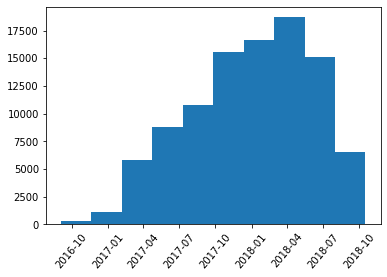

In [85]:
## 
y = pd.to_datetime(my_orders["order_purchase_date"], 
                               format = "%Y-%m-%d")
plt.hist(y)
plt.xticks(rotation=50)
from datetime import date, datetime
Y = 2000
season_dates = [("winter",date(Y,1,1),date(Y,2,20)),
                ("sping",date(Y,2,21),date(Y,5,20)),
                ("summer",date(Y,5,21),date(Y,9,20)),
                ("autumn",date(Y,9,21),date(Y,12,20)),
                ("winter",date(Y,12,21),date(Y,12,31)),]


# next(season for season, (start, end) in seasons
#                 if start <= my_date <= end)

In [120]:
seasons =  [("winter",1,51),
            ("sping",52,140),
            ("summer",141,263),
            ("autumn",264,354),
            ("winter",355,365)]
my_day_of_year = pd.to_datetime(my_orders["order_purchase_date"], 
                               format = "%Y-%m-%d").dt.dayofyear
my_season = pd.Series(index = my_orders.index,dtype=object)
for season, start, end in seasons :
    after = start <= my_day_of_year 
    before = my_day_of_year <= end
    season_index = my_day_of_year[after & before].index
    my_season[season_index] = season

order_id
e481f51cbdc54678b7cc49136f2d6af7    False
53cdb2fc8bc7dce0b6741e2150273451    False
47770eb9100c2d0c44946d9cf07ec65d    False
949d5b44dbf5de918fe9c16f97b45f8a    False
ad21c59c0840e6cb83a9ceb5573f8159    False
                                    ...  
9c5dedf39a927c1b2549525ed64a053c    False
63943bddc261676b46f01ca7ac2f7bd8    False
83c1379a015df1e13d02aae0204711ab    False
11c177c8e97725db2631073c19f07b62    False
66dea50a8b16d9b4dee7af250b4be1a5    False
Length: 99441, dtype: bool

In [117]:
my_orders.shape

(99441, 17)

In [ ]:
## automatic library -> kill kernel
# # Import library
# from clusteval import clusteval

# # Set parameters, as an example dbscan
# ce = clusteval(method='kmeans')

# # Fit to find optimal number of clusters using dbscan
# results= ce.fit(X)

# # Make plot of the cluster evaluation
# ce.plot()

# # Make scatter plot. Note that the first two coordinates are used for plotting.
# ce.scatter(X)

# # results is a dict with various output statistics. One of them are the labels.
# cluster_labels = results['labx']

In [ ]:
pipe1 = Pipeline(steps = [
    ("standardize", StandardScaler()),
    ('cluster', KMeans(n_clusters = 10, max_iter=1000))
    ])

param_grid1 = [{ 'cluster__n_clusters': np.arange(1,50,5), 
                'cluster__init':["k-means++","random"]}]

grid = GridSearchCV(pipe1, param_grid = param_grid1,
                    n_jobs=5, cv = 5, scoring= "accuracy")
grid.fit(rfm_df)
## Save dictionnary of results : 
res = grid.cv_results_
with open(res_path+"reduce_dim_products/rfm_kmeans_CV"+".pkl", "wb") as f :
    pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)
best_params = grid.best_params_
with open(res_path+"reduce_dim_products/rfm_kmeans_best_params"+".pkl", "wb") as f :
    pickle.dump(best_params, f, pickle.HIGHEST_PROTOCOL)

